In [10]:
from scipy.stats import bernoulli as bernoulli
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import random

global p_W_obs, p_S_W_obs, p_B_W_obs, p_C_WB_obs

global noise_var

noise_var = 1.9
p_W_obs = np.array([0.55, 0.45])

p_S_W_obs = np.array([[1, 0], [0, 1]]).transpose()

p_B_W_obs = np.array([[0.5, 0.5], [1, 0]]).transpose()

p_C_WB_obs = np.zeros([2, 2, 2])

p_C_WB_obs[0][0][:] = [1, 0]
p_C_WB_obs[0][1][:] = [0.5, 0.5]
p_C_WB_obs[1][0][:] = [0, 1]
p_C_WB_obs[1][1][:] = [0, 1]

p_C_WB_obs = p_C_WB_obs.transpose(2, 0, 1)


def sample_cf_policy(T, p_W, p_S_W, p_B_W, p_C_WB, my_dict):
    # S=1      => do nothing
    # S=0, B=0 => do(B=1)
    # S=0, B=1 => do nothing
    Weer = np.random.choice(2, T, p=p_W)
    Zonnebril = np.zeros((T,))
    Muts = np.zeros((T,))
    Craving = np.zeros((T,))
    i = 0
    for w in Weer:
        Zonnebril[i] = np.random.choice(2, 1, p=p_S_W[:, w])
        b = np.random.choice(2, 1, p=p_B_W[:, w])
        Muts[i] = b
        Craving[i] = np.random.choice(2, 1, p=p_C_WB[:, w, b].flatten())
        i += 1

    promotion_locations = [False] * T
    for i in range(T):
        if Zonnebril[i] == 0 and Muts[i] == 0 and my_dict['Z0', 'M0']:
            w = Weer[i]
            Craving[i] = np.random.choice(2, 1, p=p_C_WB[:, w, 1].flatten())
            promotion_locations[i] = True
        elif Zonnebril[i] == 0 and Muts[i] == 1 and my_dict['Z0', 'M1']:
            w = Weer[i]
            Craving[i] = np.random.choice(2, 1, p=p_C_WB[:, w, 1].flatten())
            promotion_locations[i] = True
        elif Zonnebril[i] == 1 and Muts[i] == 0 and my_dict['Z1', 'M0']:
            w = Weer[i]
            Craving[i] = np.random.choice(2, 1, p=p_C_WB[:, w, 1].flatten())
            promotion_locations[i] = True
        elif Zonnebril[i] == 1 and Muts[i] == 1 and my_dict['Z1', 'M1']:
            w = Weer[i]
            Craving[i] = np.random.choice(2, 1, p=p_C_WB[:, w, 1].flatten())
            promotion_locations[i] = True
        else:
            pass
    Price = np.array([10 + 10 * Craving[i] + noise_var * np.random.randn() for i in range(T)])

    return Weer, Zonnebril, Muts, Craving, Price, promotion_locations


def sample_data(T, p_W, p_S_W, p_B_W, p_C_WB):
    Weer = np.random.choice(2, T, p=p_W)
    Zonnebril = np.zeros((T,))
    Muts = np.zeros((T,))
    Craving = np.zeros((T,))
    i = 0
    for w in Weer:
        Zonnebril[i] = np.random.choice(2, 1, p=p_S_W[:, w])
        b = np.random.choice(2, 1, p=p_B_W[:, w])
        Muts[i] = b
        Craving[i] = np.random.choice(2, 1, p=p_C_WB[:, w, b].flatten())
        i += 1

    Price = np.array([10 + 10 * Craving[i] + noise_var * np.random.randn() for i in range(T)])
    return Weer, Zonnebril, Muts, Craving, Price


def obs_data(T):
    p_W = p_W_obs
    p_S_W = p_S_W_obs
    p_B_W = p_B_W_obs

    p_C_WB = p_C_WB_obs

    return sample_data(T, p_W, p_S_W, p_B_W, p_C_WB)


def policy_data(T, my_dict):
    p_W = p_W_obs
    p_S_W = p_S_W_obs
    p_B_W = p_B_W_obs

    p_C_WB = p_C_WB_obs

    return sample_cf_policy(T, p_W, p_S_W, p_B_W, p_C_WB, my_dict)


def int_on_Muts(T):
    p_W = p_W_obs
    p_S_W = p_S_W_obs
    p_B_W = p_B_W_obs

    p_C_WB = p_C_WB_obs

    p_B_W = np.array([[0, 1], [0, 1]]).transpose()
    Weer, Zonnebril, Muts, Craving, Price = sample_data(T, p_W, p_S_W, p_B_W, p_C_WB)
    return Weer, Zonnebril, Muts, Craving, Price


def int_on_Zonnebril(T):
    p_W = p_W_obs
    p_S_W = p_S_W_obs
    p_B_W = p_B_W_obs

    p_C_WB = p_C_WB_obs

    p_S_W = np.array([[0, 1], [0, 1]]).transpose()
    Weer, Zonnebril, Muts, Craving, Price = sample_data(T, p_W, p_S_W, p_B_W, p_C_WB)
    return Weer, Zonnebril, Muts, Craving, Price


def visualize_obs_data(Weer, Zonnebril, Muts, Craving, Price):
    T = len(Price)
    plt.figure()

    pwb = [Price[i] if Muts[i] == 1 else 0 for i in range(T)]
    pwoutb = [Price[i] if Muts[i] == 0 else 0 for i in range(T)]

    pwb = np.cumsum(pwb)
    pwoutb = np.cumsum(pwoutb)
    for i in np.arange(T - 1, T):
        plt.plot(range(i), pwb[0:i])
        plt.plot(range(i), pwoutb[0:i])
        plt.xlabel('Aantal klanten')
        plt.ylabel('Totale inkomsten')
        plt.legend(['Klanten met muts', 'Klanten zonder muts'])
        if i == T - 1:
            plt.show()
            plt.close()
        else:
            plt.show(block=False)
            plt.pause(0.2)
            plt.clf()
        # plt.close()

    price_w_Muts = Price[np.where(Muts == 1)]
    price_wout_Muts = Price[np.where(Muts == 0)]

    print('Gem. prijs betaald door klanten met muts: %2.4f' % np.mean(price_w_Muts))
    print('Gem. prijs betaald door klanten zonder muts: %2.4f' % np.mean(price_wout_Muts))

    plt.figure()

    pws = [Price[i] if Zonnebril[i] == 1 else 0 for i in range(T)]
    pwouts = [Price[i] if Zonnebril[i] == 0 else 0 for i in range(T)]

    pws = np.cumsum(pws)
    pwouts = np.cumsum(pwouts)
    for i in np.arange(T - 1, T):
        plt.plot(range(i), pws[0:i])
        plt.plot(range(i), pwouts[0:i])
        plt.xlabel('Aantal klanten')
        plt.ylabel('Totale inkomsten')
        plt.legend(['Klanten met zonnebril', 'Klanten zonder zonnebril'])
        if i == T - 1:
            plt.show()
            plt.close()
        else:
            plt.show(block=False)
            plt.pause(0.2)
            plt.clf()
        # plt.close()

    price_w_Zonnebril = Price[np.where(Zonnebril == 1)]
    price_wout_Zonnebril = Price[np.where(Zonnebril == 0)]

    print('Gem. prijs betaald door mensen met zonnebril: %2.4f' % np.mean(price_w_Zonnebril))
    print('Gem. prijs betaald door mensen zonder zonnebril: %2.4f' % np.mean(price_wout_Zonnebril))

    print('\n Gem. prijs betaald door alle klanten: %2.4f' % np.mean(Price))


def visualize_int_data(Weer, Zonnebril, Muts, Craving, Price, promotion):
    p = np.cumsum(Price)
    for i in np.arange(T - 1, T):
        plt.plot(range(i), p[0:i])
        # plt.plot(range(i),pwouts[0:i])
        plt.legend(['Prijs met %s promotie' % promotion])
        if i == T - 1:
            plt.show()
            plt.close()
        else:
            plt.show(block=False)
            plt.pause(0.2)
            plt.clf()
    print('Gem. prijs betaald door klanten na %s Giveaway: %2.4f' % (promotion, np.mean(Price)))


def visualize_profit_cf_policy(Price, Zonnebril, Muts, promotion_locations):
    # Muts promotion
    promotion = 'Muts'
    T = len(Price)
    baseline_price = 12
    promotion_cost = 4.7
    profit = []
    for i in range(T):
        if promotion_locations[i] == True:
            profit.append(Price[i] - baseline_price - promotion_cost)
        else:
            profit.append(Price[i] - baseline_price)
    p = np.cumsum(profit)
    plt.plot(range(T), p[0:T])
    plt.xlabel('Aantal klanten')
    plt.ylabel('Winst')
    # plt.plot(range(i),pwouts[0:i])
    plt.legend(['Winst met %s promotie' % promotion])
    plt.show(block=False)
    plt.pause(0.2)
    plt.clf()
    if p[T-1] > 0:
        print('Je verdiende %4.2f€!!' % p[T-1])
    else:
        print('Je bent %4.2f€ verloren.' % np.abs(p[T-1]))


def visualize_profit(Price, promotion):
    T = len(Price)
    baseline_price = 12
    if promotion == 'Zonnebril':
        promotion_cost = 4.3
    elif promotion == 'Muts':
        promotion_cost = 4.3
    profit = [i - baseline_price - promotion_cost for i in Price]
    p = np.cumsum(profit)
    plt.plot(range(T), p[0:T])
    plt.xlabel('Aantal klanten')
    plt.ylabel('Winst')
    # plt.plot(range(i),pwouts[0:i])
    plt.legend(['Winst met %s promotie' % promotion])
    plt.show(block=False)
    plt.pause(0.2)
    plt.clf()
    if p[T-1] > 0:  # np.sum(p[0:i])>0:
        print('Je verdiende %4.2f€!!' % p[T-1])
    else:
        print('Je bent %4.2f€ verloren.' % np.abs(p[T-1]))


def slow_type(t):
    typing_speed = 200  # wpm
    for l in t:
        sys.stdout.write(l)
        sys.stdout.flush()
        time.sleep(random.random() * 10.0 / typing_speed)
    print('')


def narration():
    slow_type('Proficiat!')
    time.sleep(0.5)
    slow_type('Je hebt zojuist een limonadestand aangekocht. Jij verkoopt limonade aan een prijs die de klanten zelf mogen kiezen.')
    time.sleep(0.5)
    slow_type('De vorige eigenaar geeft je wat data over welke klanten hoe veel betaalden in het verleden.')
    time.sleep(0.5)
    slow_type('Je kan kijken naar deze data om te beslissen welk promotie artikel jij zou weggeven om je winsten te verhogen')


def narration2():
    slow_type('Uitgerust met de net vergaarde kennis over causaliteit en associatie, bepaal jij nu een policy om je winst te maximaliseren.')
    time.sleep(0.5)
    slow_type('We geven slechts aan een aantal klanten een muts.')
    time.sleep(0.5)
    slow_type('Er zijn klanten met zowel zonnebril als muts, met geen van beide of met één van beide.')
    time.sleep(0.5)
    slow_type('Geef voor elk soort klant aan of je ze een muts zou geven of niet door ja/nee in te geven.')


def main():
    # observational data
    narration()
    T = 100

    Weer, Zonnebril, Muts, Craving, Price = obs_data(T)

    visualize_obs_data(Weer, Zonnebril, Muts, Craving, Price)

    main_flag = 1
    while main_flag:
        print('Geef in wel promotie artikel je weggeeft. Z voor zonnebril, M voor muts. Duw daarna op Enter')
        flag = 1
        while flag:
            val = input()
            if val == 'Z' or val == 'z':
                promotion = 'Zonnebril'
                flag = 0
            elif val == 'M' or val == 'm':
                promotion = 'Muts'
                flag = 0
            else:
                print('Ongeldige input, probeer opnieuw:')
        print('Je hebt beslist om %s weg te geven. Laten we de winstcurve bekijken: ' % promotion)
        if promotion == 'Zonnebril':
            Weer, Zonnebril, Muts, Craving, Price = int_on_Zonnebril(T)
            visualize_profit(Price, 'Zonnebril')
        elif promotion == 'Muts':
            Weer, Zonnebril, Muts, Craving, Price = int_on_Muts(T)
            visualize_profit(Price, 'Muts')
        local_flag = 1
        while local_flag:
            val = input('Wil je opnieuw proberen? (Ja/Nee)? \n')
            if val == 'Ja' or val == 'ja' or val == 'JA':
                local_flag = 0
                break
            elif val == 'Nee' or val == 'NEE' or val == 'nee':
                local_flag = 0
                main_flag = 0
                print('Bedankt om te spelen!')
                break
            else:
                print('Ongeldige input, probeer opnieuw:')


def main2():
    narration2()
    T = 100
    main_flag = 1
    while main_flag:
        my_dict = {}
        for i in range(2):
            for j in range(2):
                my_key = 'Z' + str(i), 'M' + str(j)
                my_dict[(my_key)] = False

        #         my_dict[('S1','B1')]=False
        #         my_dict[('S1','B0')]=False
        #         my_dict[('S0','B1')]=False
        #         my_dict[('S0','B0')]=False
        for i in range(2):
            for j in range(2):
                my_key = 'Z' + str(i), 'M' + str(j)
                print('Klanten met Z=%s, M=%s:' % (str(i), str(j)))
                flag = 1
                while flag:
                    val = input()
                    if val == 'Ja' or val == 'JA' or val == 'ja':
                        my_dict[my_key] = True
                        flag = 0
                    elif val == 'Nee' or val == 'nee' or val == 'NEE':
                        pass
                        flag = 0
                    else:
                        print('Ongeldige input, probeer opnieuw:')

        #         print('Customers w/ S=1, B=0:')
        #         flag=1
        #         while flag:
        #             val = input()
        #             if val == 'Y' or val == 'y':
        #                 my_dict[('S1','B0')]=True
        #                 flag=0
        #             elif val == 'N' or val == 'n':
        #                 pass
        #                 flag=0
        #             else:
        #                 print('Invalid input, please try again:')
        #         print('Customers w/ S=0, B=1:')
        #         flag=1
        #         while flag:
        #             val = input()
        #             if val == 'Y' or val == 'y':
        #                 my_dict[('S0','B1')]=True
        #                 flag=0
        #             elif val == 'N' or val == 'n':
        #                 pass
        #                 flag=0
        #             else:
        #                 print('Invalid input, please try again:')
        #         print('Customers w/ S=0, B=0:')
        #         flag=1
        #         while flag:
        #             val = input()
        #             if val == 'Y' or val == 'y':
        #                 my_dict[('S0','B0')]=True
        #                 flag=0
        #             elif val == 'N' or val == 'n':
        #                 pass
        #                 flag=0
        #             else:
        #                 print('Invalid input, please try again:')
        s = ''
        for i in range(2):
            for j in range(2):
                my_key = 'Z' + str(i), 'M' + str(j)
                if my_dict[(my_key)] == True:
                    s += ' '
                    s += 'Z' + str(i) + 'M' + str(j)

        print('Je hebt beslist om een muts weg te geven aan de klanten: %s' % s)

        Weer, Zonnebril, Muts, Craving, Price, promotion_locations = policy_data(T, my_dict)
        visualize_profit_cf_policy(Price, Zonnebril, Muts, promotion_locations)
        local_flag = 1
        while local_flag:
            val = input('Wil je opnieuw proberen? (Ja/Nee)?\n')
            if val == 'Ja' or val == 'JA' or val == 'ja':
                local_flag = 0
                break
            elif val == 'Nee' or val == 'NEE' or val == 'nee':
                local_flag = 0
                main_flag = 0
                print('Bedankt om te spelen!')
                break
            else:
                print('Ongeldige input, probeer opnieuw:')

            # if __name__ == "__main__":
#     #main()
#     main2()



Proficiat!
Je hebt zojuist een limonadestand aangekocht. Jij verkoopt limonade aan een prijs die de klanten zelf mogen kiezen.
De vorige eigenaar geeft je wat data over welke klanten hoe veel betaalden in het verleden.
Je kan kijken naar deze data om te beslissen welk promotie artikel jij zou weggeven om je winsten te verhogen


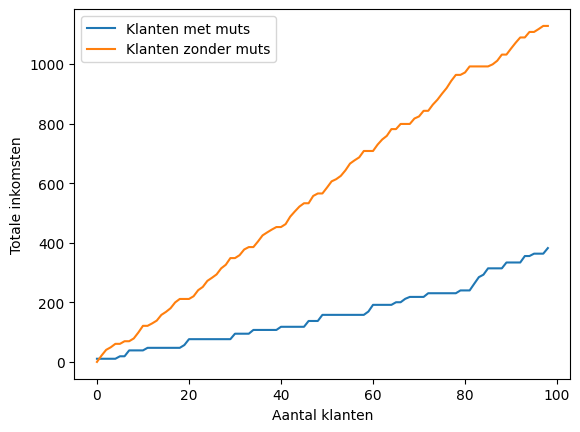

Gem. prijs betaald door klanten met muts: 14.6991
Gem. prijs betaald door klanten zonder muts: 15.4037


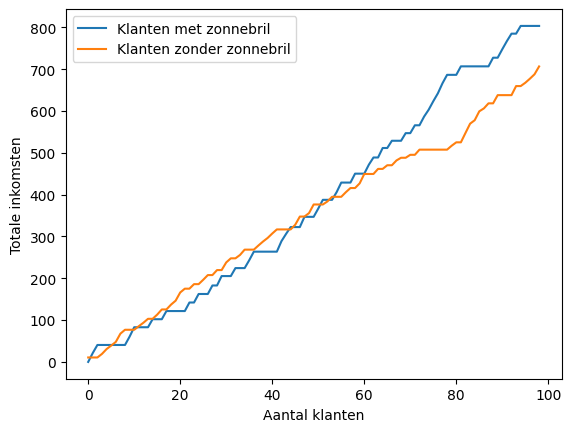

Gem. prijs betaald door mensen met zonnebril: 20.0868
Gem. prijs betaald door mensen zonder zonnebril: 11.9763

 Gem. prijs betaald door alle klanten: 15.2205
Geef in wel promotie artikel je weggeeft. Z voor zonnebril, M voor muts. Duw daarna op Enter


 Z


Je hebt beslist om Zonnebril weg te geven. Laten we de winstcurve bekijken: 


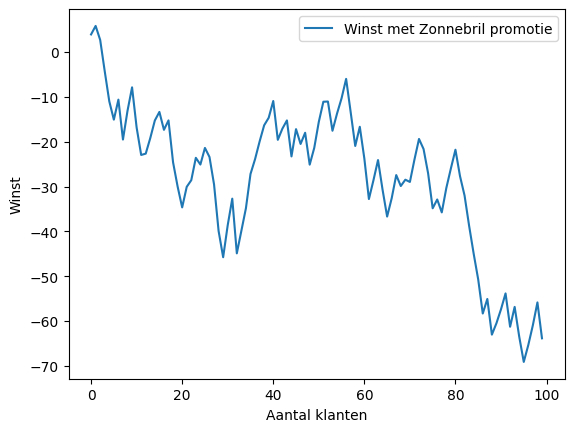

Je bent 63.84€ verloren.


In [ ]:
main()